In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import sys
import cv2 as cv
from tqdm import tqdm

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

### Importing my Data

In [3]:
df_cat = pd.read_csv(f'{combine_fold}/cosmos2020-categorised-interactions.csv', index_col = 0)

In [10]:
df_cat.head()

,ORyan23_ID,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage3,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-0.000010,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,861738,stage1,150.645118,2.237538,10033.689453,22720.843750,0.000039,0.000078,0.000013,...,-9.574272,-9.548649,-9.503962,-9.439343,-9.384205,0.240042,0.281559,0.330791,0.384371,0.436491
2,4000705539529,1284864,stage1,149.686223,2.637412,33027.406250,32317.517578,0.000031,0.000030,0.000001,...,-9.669377,-9.614943,-9.570104,-9.533121,-9.476167,0.094187,0.114436,0.140990,0.159430,0.183608
3,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-0.000003,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
4,4000705540034,1304538,stage1,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-0.000006,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727


In [9]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best > 6.5')

In [28]:
df_IDS = (
    df_red[['ID', 'ID_COSMOS2015']]
)

### Importing Dervish Data

In [16]:
environ_data = pd.read_csv(f'{cos_dat_fold}/darvish17-environ.csv')

In [20]:
len(environ_data)

45421

In [43]:
environ_data_red = environ_data.query('flag == 0').rename(columns = {'ID' : 'ID_COSMOS2015'})

In [44]:
len(environ_data_red)

38865

Match on ID_COSMOS2015

### Matching Catalogues

In [45]:
df_environ_match = (
    df_IDS.merge(environ_data_red, on = 'ID_COSMOS2015', how = 'left')
)

In [46]:
matched_red = df_environ_match[['ID', 'density']].dropna()
matched_red

,ID,density
2,1284864,1.51
4,1304538,0.96
5,1310001,3.08
6,1308927,2.78
7,1311422,2.26
...,...,...
3763,1078421,6.49
3765,715824,3.46
3767,1157587,4.71
3770,1203157,4.01


In [47]:
matched_red.density.min()

0.05

In [49]:
matched_red.density.max()

52.78

In [50]:
log_matched_red = (
    matched_red
    .assign(log_density = matched_red.density.apply(lambda x: np.log10(x)))
)

### Diagnostics of Environment Measure

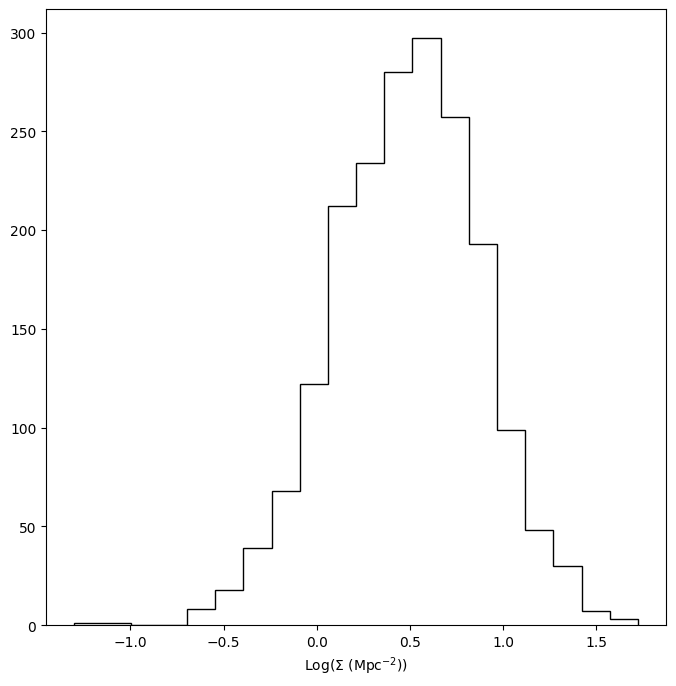

In [53]:
plt.figure(figsize = (8,8))
plt.hist(np.array(log_matched_red.log_density), bins = 20, histtype='step', color='black')
plt.xlabel('Log($\Sigma$ (Mpc$^{-2}$))')
plt.show()

In [57]:
df_cat = df_red[['ID', 'category', 'lp_mass_best', 'ez_sfr']]

In [60]:
df_environ_merg = log_matched_red.merge(df_cat, on = 'ID', how = 'left')
df_environ_merg

,ID,density,log_density,category,lp_mass_best,ez_sfr
0,1284864,1.51,0.178977,stage1,10.17034,0.901761
1,1304538,0.96,-0.017729,stage1,9.96798,1.101499
2,1310001,3.08,0.488551,stage4,10.41827,1.083541
3,1308927,2.78,0.444045,stage4,10.03523,1.198906
4,1311422,2.26,0.354108,stage2,9.64588,0.392114
...,...,...,...,...,...,...
1912,1078421,6.49,0.812245,stage2,10.82210,-1.224104
1913,715824,3.46,0.539076,stage1,10.58314,1.029518
1914,1157587,4.71,0.673021,stage4,10.56569,0.131293
1915,1203157,4.01,0.603144,stage1,10.25633,0.975221


In [61]:
df_environ_merg.category.value_counts()

stage4    629
stage2    519
stage1    420
stage3    349
Name: category, dtype: int64

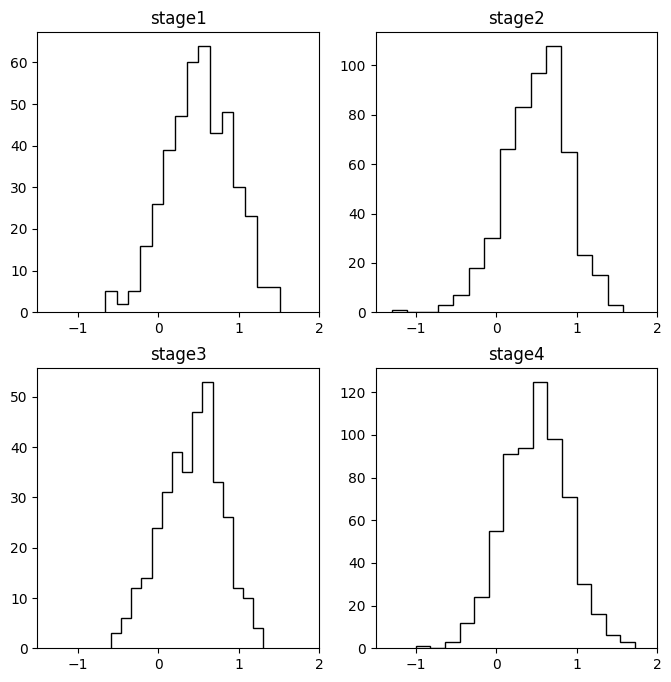

In [71]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        densities = np.array(df_environ_merg.query('category == @stage').log_density)
        
        ax[i,j].hist(densities, bins = 15, histtype='step', color='black')
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([-1.5, 2.0])
        
        counter += 1

### Controlling for Environment and Stage

,ID,density,log_density,category,lp_mass_best,ez_sfr
0,1284864,1.51,0.178977,stage1,10.17034,0.901761
1,1304538,0.96,-0.017729,stage1,9.96798,1.101499
2,1310001,3.08,0.488551,stage4,10.41827,1.083541
3,1308927,2.78,0.444045,stage4,10.03523,1.198906
4,1311422,2.26,0.354108,stage2,9.64588,0.392114
...,...,...,...,...,...,...
1912,1078421,6.49,0.812245,stage2,10.82210,-1.224104
1913,715824,3.46,0.539076,stage1,10.58314,1.029518
1914,1157587,4.71,0.673021,stage4,10.56569,0.131293
1915,1203157,4.01,0.603144,stage1,10.25633,0.975221


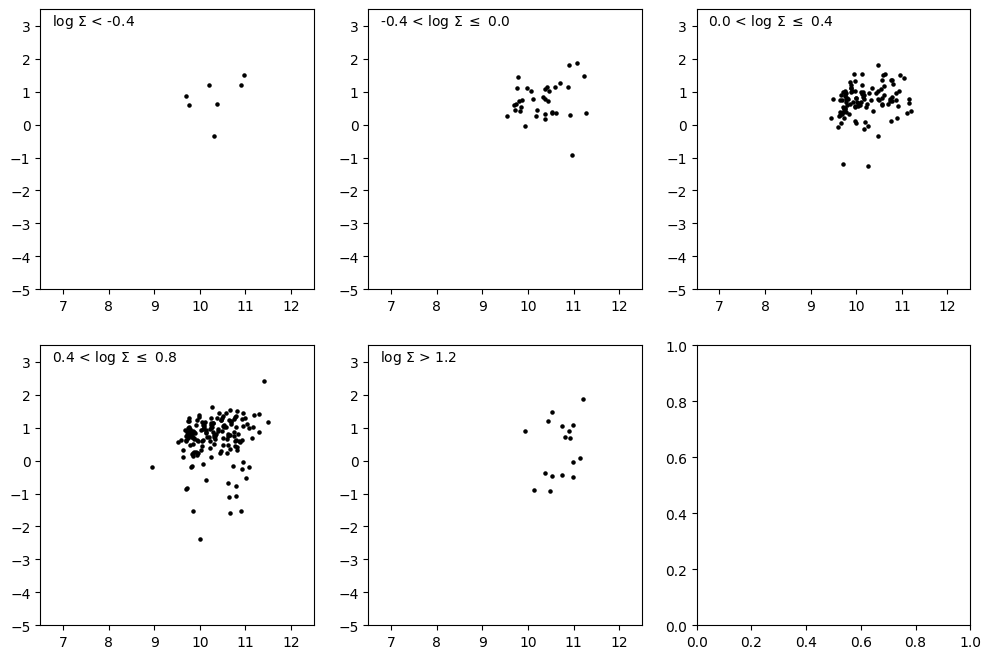

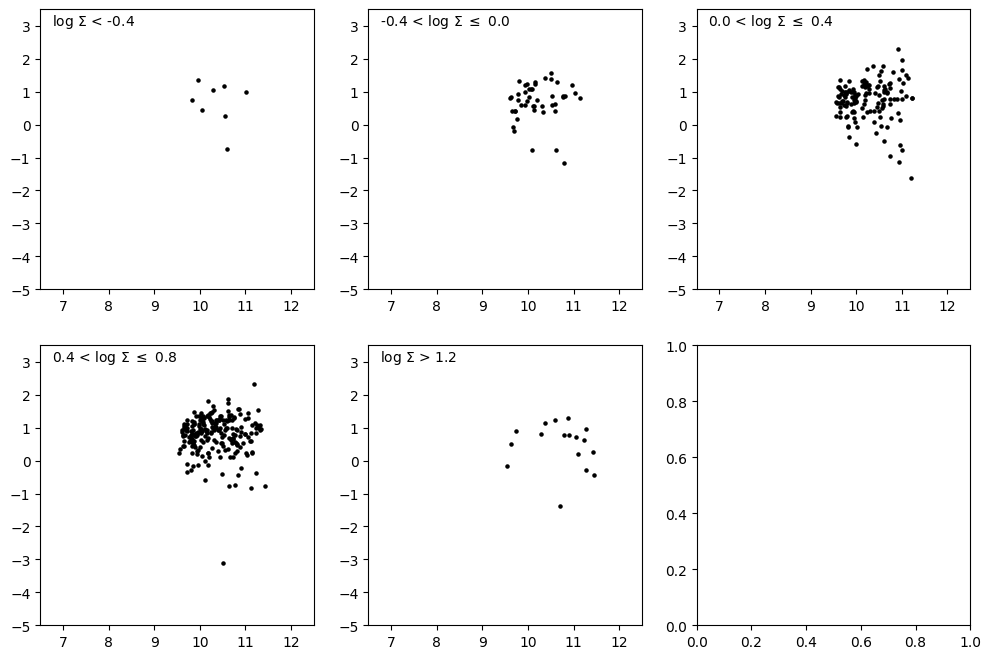

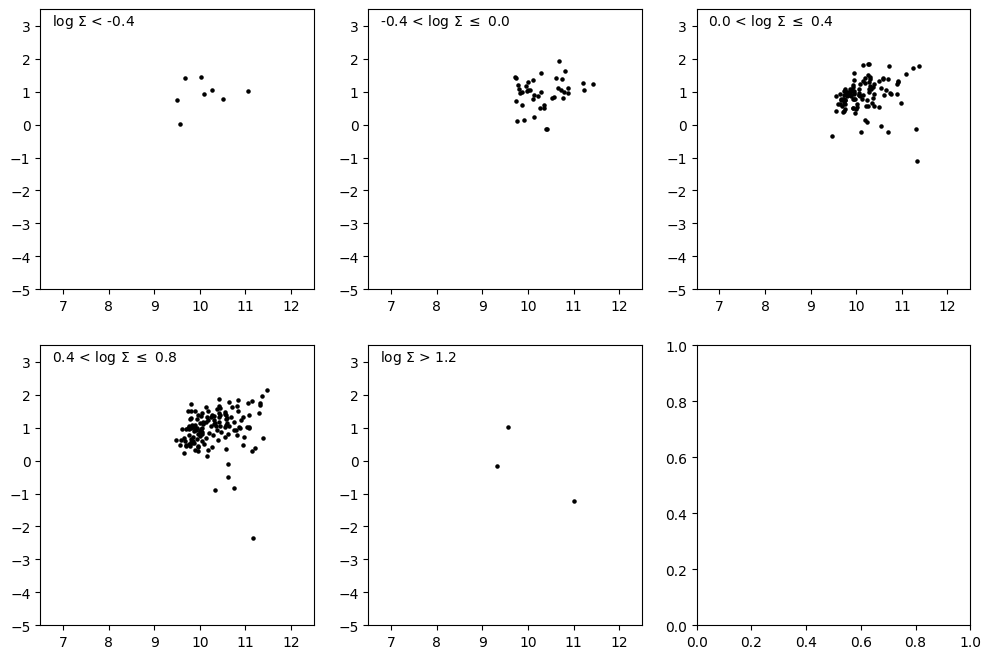

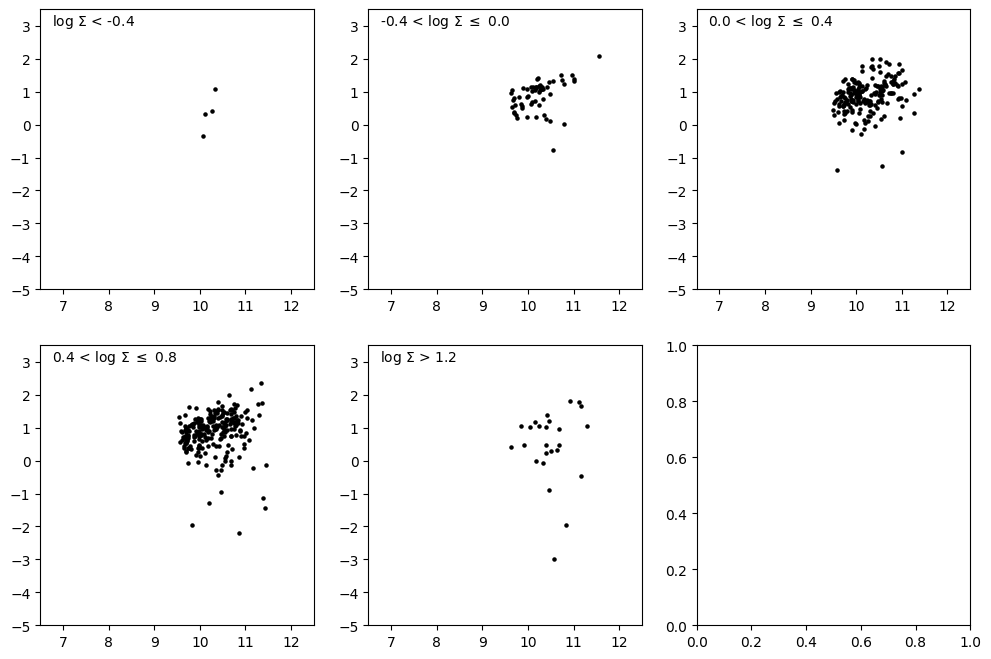

In [112]:
counter_stage = 1
cuts = [-0.4, 0.0, 0.4, 0.8, 1.2]
for i in range(4):
    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12,8))
    stage = f'stage{counter_stage}'
    df_stage = df_environ_merg.query('category == @stage')
    counter_env = 0
    for j in range(2):
        for k in range(3):
            if counter_env == 0:
                cut = cuts[counter_env]
                df_env = df_stage.query('log_density < @cut')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = 'black')
                ax[j,k].text(6.75, 3, f'log $\Sigma$ < {cut}')
                ax[j,k].set_xlim([6.5,12.5])
                ax[j,k].set_ylim([-5,3.5])
                counter_env += 1
            elif counter_env < 4:
                cut_1 = cuts[counter_env - 1]
                cut_2 = cuts[counter_env]
                df_env = df_stage.query('log_density > @cut_1 and log_density <= @cut_2')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = 'black')
                ax[j,k].text(6.75, 3, f'{cut_1} < log $\Sigma$ $\leq$ {cut_2}')
                ax[j,k].set_xlim([6.5,12.5])
                ax[j,k].set_ylim([-5,3.5])
                counter_env += 1
            elif counter_env == 4:
                cut = cuts[counter_env]
                df_env = df_stage.query('log_density > @cut')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = 'black')
                ax[j,k].text(6.75, 3, f'log $\Sigma$ > {cut}')
                ax[j,k].set_xlim([6.5,12.5])
                ax[j,k].set_ylim([-5,3.5])
                counter_env += 1
                
    counter_stage += 1